In [1]:
%cd ..

/home/seb/Perso/git/sudoku/sudoku_clean_v2


In [2]:
import torch
import pytorch_lightning as pl
from torch import nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sudoku.models import SmallNetBis, SymPreprocess
from sudoku.loader import DataIterBuffer, train_dataset, test_dataset, data_loader, get_datasets
from sudoku.helper import display_as_dataframe

from collections import deque
from typing import Tuple


from torchmetrics import AUROC
from torch.utils.data.dataset import IterableDataset
from torch.utils.data import  DataLoader

from pytorch_lightning.callbacks import ModelCheckpoint
from lightning_lite.utilities.seed import seed_everything

import numpy as np


import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))


In [3]:
tensorboard = pl.loggers.TensorBoardLogger(save_dir="")
torch.cuda.is_available()


True

In [4]:
seed_everything(seed=1)

Global seed set to 1


1

In [5]:
train_dataset, test_dataset = get_datasets(train_size=1280, test_size=1280)

In [6]:
test_x, test_y = tuple(next(iter(data_loader(batch_size=1)[1])))

In [7]:
def transform_to_number_1(input_tensor):
    tensor = input_tensor.reshape(input_tensor.shape[0], 2, 9, 9, 9)
    max_value, chiffre_tensor = torch.max(tensor[:,1,:,:,:],-1)
    chiffre_tensor = chiffre_tensor+1
    return chiffre_tensor

def transform_to_number_0(input_tensor):
    tensor = input_tensor.reshape(input_tensor.shape[0], 2, 9, 9, 9)
    max_value, chiffre_tensor = torch.min(tensor[:,0,:,:,:],-1)
    chiffre_tensor = chiffre_tensor+1
    return chiffre_tensor

In [8]:
torch.sigmoid(torch.tensor(4))

tensor(0.9820)

- test clip -4 4: ne fonctionne  pas
- analyse des distributions:
- la recherches des absent marche : beaucoup d'exemple dans la data.
- la recherche des present est disfonctionel: très très peu d'exemple

idée:
- entrainer la recherche des present seulement sur le second tour et plus.
- entrainer la recherche des present seulement sur les nons absents et non present?

In [9]:
def coef_scheduler(epoch,start_decay=10, end_decay=18):
    if epoch<= start_decay:
        return 1.
    if epoch>=end_decay:
        return 0.1
    coef = 1-0.9*(epoch-start_decay)/(end_decay-start_decay)
    
    return coef

In [10]:
class SudokuLightning(pl.LightningModule):
    def __init__(
        self,
        lr=0.1,
        train_dataset=train_dataset,
        val_dataset=test_dataset,
        margin=0.1,
        prev_nets = None,
        coef_0 = 10
    ):
        
        super().__init__()
        self.net=SmallNetBis()
        self.sym_preprocess = SymPreprocess()
        pos_weight = torch.ones((2,9*9*9))
        pos_weight[0,:] = 1./8.
        pos_weight[1,:]= 1.
        pos_weight /= coef_0
        weight = torch.ones((2,9*9*9))
        weight[0,:] = 8.
        weight[1,:]= 1.
        weight *= coef_0
        
        self.bcewll = nn.BCEWithLogitsLoss(pos_weight=pos_weight, weight=weight, reduce=False)
        self.lr = lr
        self.auroc = AUROC(task='binary')
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.n_bins = 99
        self.bins = np.linspace(0,1,self.n_bins+1)
        self.train_freq_abs_gr_0 = np.zeros((self.n_bins,))
        self.train_freq_abs_gr_1 = np.zeros((self.n_bins,))
        self.train_freq_pres_gr_0 = np.zeros((self.n_bins,))
        self.train_freq_pres_gr_1 = np.zeros((self.n_bins,))
        
        self.margin = margin
        self.threshold_pres = None
        self.threshold_abs = None
        self.threshold_pres_train = -10
        self.threshold_abs_train = -10

        self.prev_nets = prev_nets
        self.below_threshold_coef = 1

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def forward(self, x):
        x = self.sym_preprocess.forward(x)
        return self.net(x)
    
    def predict_from_net(self, x, net, th_abs, th_pres):
        x = self.sym_preprocess.forward(x)
        x = net(x)
        new_x = torch.empty(x.shape, device=x.device)
        new_x[:,0] = (x[:,0] > th_abs).float()
        new_x[:,1] = (x[:,1] > th_pres).float()
        return new_x
    
    def predict(self, x):
        return predict_from_net(x,self.net, self.threshold_abs, self.threshold_pres)
    
    def process_batch(self, batch, dataset):
        x, y = batch
        new_x = torch.zeros(x.shape, device=x.device)

        if self.prev_nets:
            for net, (th_abs, th_pres) in self.prev_nets:
                with torch.no_grad():
                    sub_new_x = self.predict_from_net(x, net.to(x.device), th_abs, th_pres)
                new_x[sub_new_x==1]=1
            new_x[x==1]=1
            new_x[(new_x==1)&(y==0)]=0
            mask_no_improve = new_x.sum(dim=(1,2))<=x.sum(dim=(1,2))
            dataset.append(new_x[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())

            if mask_no_improve.sum()>0:       
                return x[mask_no_improve], y[mask_no_improve], y[mask_no_improve]
            else:
                return None, None, None
        return x,y,y
        
    @staticmethod
    def mask_uncomplete(x,y):
        mask_uncomplete = (x.reshape(-1,2,9,9,9).sum(-1)<torch.tensor((8,1)).to(x).reshape(1,2,1,1))
        mask_uncomplete = mask_uncomplete.reshape(-1,2,9,9,1)
        mask = ((x==0).reshape(-1,2,9,9,9)*mask_uncomplete).reshape(-1,2,9**3)
        mask = mask.float()
        return mask
    
    def computing_loss(self, x, y, output, true_y):
        loss = self.bcewll(output, y)
        # mask = (x==0).float()
#         mask = ((x==0)&(output.detach()<4)).float()
        mask = self.mask_uncomplete(x, y)
#         th_enforce = 1.5
#         mask_add = ((output.detach()>th_enforce)&(y==0)).float()
#         loss+=5*loss*mask_add*(output.detach()-th_enforce)
        
#         mask_below_th = torch.zeros(x.shape, device=x.device)
#         mask_below_th[:,0][(output[:,0]<self.threshold_abs_train)&(y[:,0]==1)]=1
#         mask_below_th[:,1][(output[:,1]<self.threshold_pres_train)&(y[:,1]==1)]=1
#         coef = coef_scheduler(self.current_epoch)
#         loss = loss+loss*mask_below_th*(coef-1)
#         if self.current_epoch >= 35:
#             mask_lower_than_0 = (output<0)&(y==1)
#             loss = loss*mask_lower_than_0.float()
        loss = (loss*mask).sum()
        
        return loss

    def training_step(self, batch, batch_idx):
        x, y, true_y = self.process_batch(batch, self.train_data_iter)
        if x is None:
            return None
        
        output = self.forward(x)
        loss = self.computing_loss(x, y, output, true_y)
        ##
#         y[:,0][output[:,0].detach()<self.threshold_switch_abs]=0
#         y[:,1][output[:,1].detach()<self.threshold_switch_pres]=0
        ##

        
        loss_0 = F.binary_cross_entropy_with_logits(output[:,[0],:], y[:,[0],:])
        loss_1 = F.binary_cross_entropy_with_logits(output[:,[1],:], y[:,[1],:])
        self.log_dict({'loss_1': loss_1, 'loss_0': loss_0}, on_epoch=True)
        accuracy_1 = torch.mean(torch.eq(transform_to_number_1(output), transform_to_number_1(x)).type(torch.float))
        accuracy_0 = torch.mean(torch.eq(transform_to_number_0(output), transform_to_number_0(x)).type(torch.float))
        self.log('auroc_0', self.auroc(output[:, [0],:],y[:, [0],:]))
        self.log('auroc_1', self.auroc(output[:, [1],:],y[:, [1],:]))
        self.log_dict({'accuracy_1': accuracy_1, 'accuracy_0': accuracy_0}, on_epoch=True)
        self.log('train_loss', loss)
        
#         max_th_abs = output[:,0][(x[:,0]==0)&(y[:,0]==0)].max().item()
#         if self.threshold_abs_train< max_th_abs+self.margin:
#             self.threshold_abs_train = max_th_abs+self.margin
#         max_th_pres = output[:,1][(x[:,1]==0)&(y[:,1]==0)].max().item()
#         if self.threshold_pres_train< max_th_pres+self.margin:
#             self.threshold_pres_train = max_th_pres+self.margin        
        
#         abs_gr_0 = torch.sigmoid(output[:,0][(x[:,0]==0)&(y[:,0]==0)])
#         abs_gr_1 = torch.sigmoid(output[:,0][(x[:,0]==0)&(y[:,0]==1)])
#         pres_gr_0 = torch.sigmoid(output[:,1][(x[:,1]==0)&(y[:,1]==0)])
#         pres_gr_1 = torch.sigmoid(output[:,1][(x[:,1]==0)&(y[:,1]==1)])
        
#         freq, _bins = np.histogram(abs_gr_0.detach().cpu().numpy(), bins=self.bins) 
#         self.train_freq_abs_gr_0 += freq
#         freq, _bins = np.histogram(abs_gr_1.detach().cpu().numpy(), bins=self.bins) 
#         self.train_freq_abs_gr_1 += freq
#         freq, _bins = np.histogram(pres_gr_0.detach().cpu().numpy(), bins=self.bins) 
#         self.train_freq_pres_gr_0 += freq
#         freq, _bins = np.histogram(pres_gr_1.detach().cpu().numpy(), bins=self.bins) 
#         self.train_freq_pres_gr_1 += freq
    
        
        
#         new_X = (output.detach()>0).float()
#         new_X[:,0] = (output[:,0].detach()>self.threshold_abs_train).float()
#         new_X[:,1] = (output[:,1].detach()>self.threshold_pres_train).float()
#         new_X[x.detach()==1]=1
#         mask_no_improve = new_X.sum(dim=(1,2))<=x.sum(dim=(1,2))
#         self.no_improve_counter+= mask_no_improve.sum().item()
#         self.item_counter+= mask_no_improve.shape[0]
#         self.train_data_iter.append(new_X[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())
        # TODO rempve solved
        new_X = (output.detach()>0).float()
        new_X[:,0] = (output[:,0].detach()>self.threshold_abs_train).float()
        new_X[:,1] = (output[:,1].detach()>self.threshold_pres_train).float()
        new_X[x.detach()==1]=1
        mask_no_improve = new_X.sum(dim=(1,2))<=x.sum(dim=(1,2))
#         self.no_improve_counter+= mask_no_improve.sum().item()
#         self.item_counter+= mask_no_improve.shape[0]
        self.train_data_iter.append(new_X[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())

        return loss
    
    def on_validation_epoch_end(self):
        tensorboard = self.logger.experiment
        f = plt.figure()
        fig, (ax1,ax2) = plt.subplots(2,1)
        
        ax1.axvline(sigmoid(self.threshold_abs_train), color='black')
        ax1.bar(self.bins[:-1], self.train_freq_abs_gr_0, width=np.diff(self.bins)/2, align="edge", label='gr_0')
        ax1.bar(self.bins[:-1], self.train_freq_abs_gr_1, width=np.diff(self.bins)/2, align="center", label='gr_1')
        ax1.set_yscale('log')
        ax1.set_title('abs')
        
        ax2.axvline(sigmoid(self.threshold_pres_train), color='black')
        ax2.bar(self.bins[:-1], self.train_freq_pres_gr_0, width=np.diff(self.bins)/2, align="edge", label='gr_0')
        ax2.bar(self.bins[:-1], self.train_freq_pres_gr_1, width=np.diff(self.bins)/2, align="center", label='gr_1')
        ax2.set_yscale('log')
        plt.legend()
        ax2.set_title('pres')
        

        tensorboard.add_figure('hist', f)
        plt.show()
        plt.close()
        self.log('no_improve_counter', self.no_improve_counter)
        print(f"No improve counter : {self.no_improve_counter}")
        print(f"item counter : {self.item_counter}")
        print(f"ratio : {self.no_improve_counter/(self.item_counter+1)}")
        ratio_number_predicted_per_items =  self.number_predicted/(self.item_counter+1)
        print(f" ratio number predicted/items: {ratio_number_predicted_per_items}")
        self.log("ratio_number_predicted_per_items", ratio_number_predicted_per_items)
        print(f"current epoch: {self.current_epoch}")
        self.no_improve_counter = 0
        self.item_counter = 0
        self.number_predicted = 0
        
        self.train_freq_pres_gr_0 = np.zeros((self.n_bins,))
        self.train_freq_pres_gr_1 = np.zeros((self.n_bins,))
        self.train_freq_abs_gr_0 = np.zeros((self.n_bins,))
        self.train_freq_abs_gr_1 = np.zeros((self.n_bins,))
        
        
        self.threshold_abs = self.threshold_abs_train
        self.threshold_pres = self.threshold_pres_train

    def on_validation_start(self):
                
        self.no_improve_counter = 0
        self.item_counter = 0
        self.number_predicted = 0
        
    def validation_step(self, batch, batch_idx):
        
        x, y, true_y = self.process_batch(batch, self.val_data_iter)
        if x is None:
            return None
        
        output = self.forward(x)
        val_loss = self.computing_loss(x, y, output, true_y)

        max_th_abs = output[:,0][(x[:,0]==0)&(y[:,0]==0)].max().item()
        if self.threshold_abs_train< max_th_abs+self.margin:
            self.threshold_abs_train = max_th_abs+self.margin
        max_th_pres = output[:,1][(x[:,1]==0)&(y[:,1]==0)].max().item()
        if self.threshold_pres_train< max_th_pres+self.margin:
            self.threshold_pres_train = max_th_pres+self.margin     
        
        self.log("val_loss", val_loss)
        loss_0 = F.binary_cross_entropy_with_logits(output[:,[0],:], y[:,[0],:])
        loss_1 = F.binary_cross_entropy_with_logits(output[:,[1],:], y[:,[1],:])
        self.log_dict({'val_loss_1': loss_1, 'val_loss_0': loss_0})
        accuracy_1 = torch.mean(torch.eq(transform_to_number_1(output), transform_to_number_1(x)).type(torch.float))
        accuracy_0 = torch.mean(torch.eq(transform_to_number_0(output), transform_to_number_0(x)).type(torch.float))
        self.log_dict({'val_accuracy_1': accuracy_1, 'val_accuracy_0': accuracy_0}, on_epoch=True)
        new_X = (output.detach()>0).float()
        if self.threshold_abs:
            new_X[:,0] = (output[:,0].detach()>self.threshold_abs).float()
            new_X[:,1] = (output[:,1].detach()>self.threshold_pres).float()
        new_X[x.detach()==1]=1
        mask_no_improve = new_X.sum(dim=(1,2))<=x.sum(dim=(1,2))
        abs_gr_0 = torch.sigmoid(output[:,0][(x[:,0]==0)&(y[:,0]==0)])
        abs_gr_1 = torch.sigmoid(output[:,0][(x[:,0]==0)&(y[:,0]==1)])
        pres_gr_0 = torch.sigmoid(output[:,1][(x[:,1]==0)&(y[:,1]==0)])
        pres_gr_1 = torch.sigmoid(output[:,1][(x[:,1]==0)&(y[:,1]==1)])
        
        freq, _bins = np.histogram(abs_gr_0.detach().cpu().numpy(), bins=self.bins) 
        self.train_freq_abs_gr_0 += freq
        freq, _bins = np.histogram(abs_gr_1.detach().cpu().numpy(), bins=self.bins) 
        self.train_freq_abs_gr_1 += freq
        freq, _bins = np.histogram(pres_gr_0.detach().cpu().numpy(), bins=self.bins) 
        self.train_freq_pres_gr_0 += freq
        freq, _bins = np.histogram(pres_gr_1.detach().cpu().numpy(), bins=self.bins) 
        self.train_freq_pres_gr_1 += freq
    
        
#         batch = transfer_batch_to_device(batch)
        new_X = (output.detach()>0).float()
        new_X[:,0] = (output[:,0].detach()>self.threshold_abs_train).float()
        new_X[:,1] = (output[:,1].detach()>self.threshold_pres_train).float()
        new_X[x.detach()==1]=1
        mask_no_improve = new_X.sum(dim=(1,2))<=x.sum(dim=(1,2))
        self.no_improve_counter+= mask_no_improve.sum().item()
        self.item_counter+= mask_no_improve.shape[0]
        self.number_predicted += new_X.sum().item()-x.sum().item()
#         self.train_data_iter.append(new_X[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())
        

        self.val_data_iter.append(new_X[~mask_no_improve].cpu(), y[~mask_no_improve].clone().cpu())

    def train_dataloader(self):
        self.train_data_iter = DataIterBuffer(self.train_dataset)
        return DataLoader(self.train_data_iter, 32)
        
    def val_dataloader(self):
        self.val_data_iter = DataIterBuffer(self.test_dataset)
        return DataLoader(self.val_data_iter, 32)
    

In [11]:
class DistillationLightning(SudokuLightning):
    def process_batch(self, batch, _, validation=True):
        x, y = batch
        new_y = torch.zeros(y.shape, device=y.device)

        if self.prev_nets:
            for net, (th_abs, th_pres) in self.prev_nets:
                with torch.no_grad():
                    sub_new_y = self.predict_from_net(x, net.to(x.device), th_abs, th_pres)
                new_y[sub_new_y==1]=1
            new_y[x==1]=1
            new_y[(new_y==1)&(y==0)]=0
            return x, new_y, y
        return x,y, y
    
    def computing_loss(self, x, y, output, true_y):
        loss = self.bcewll(output, y)
        mask = ((x==0)& ~((true_y==1)&(y==0))).float()
        loss = (loss*mask).sum()        
        return loss

    
    

In [12]:
# class Speeduplightning(SudokuLightning):
#     def process_batch(self, batch, dataset):
#         x, y = batch
#         new_x = torch.zeros(x.shape, device=x.device)

#         if self.prev_nets:
#             for net, (th_abs, th_pres) in self.prev_nets:
#                 with torch.no_grad():
#                     sub_new_x = self.predict_from_net(x, net.to(x.device), th_abs, th_pres)
#                 new_x[sub_new_x==1]=1
#             new_x[x==1]=1
#             new_x[(new_x==1)&(y==0)]=0       
#             return new_x, y, y

#         return x,y,y

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNetBis       | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


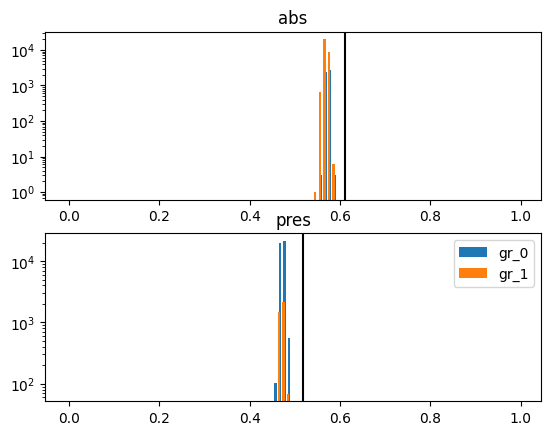

No improve counter : 64
item counter : 64
ratio : 0.9846153846153847
 ratio number predicted/items: 0.0
current epoch: 0


/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('no_improve_counter', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

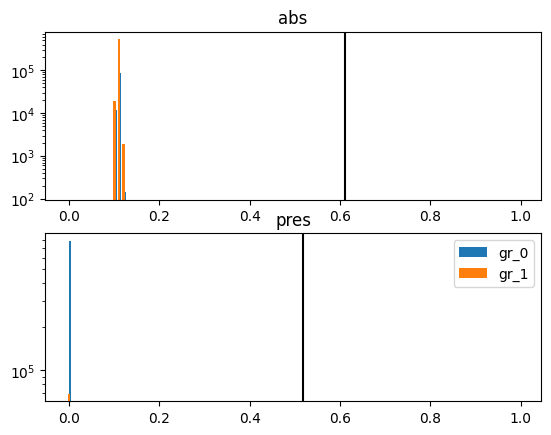

No improve counter : 1216
item counter : 1216
ratio : 0.9991783073130649
 ratio number predicted/items: 0.0
current epoch: 0


Validation: 0it [00:00, ?it/s]

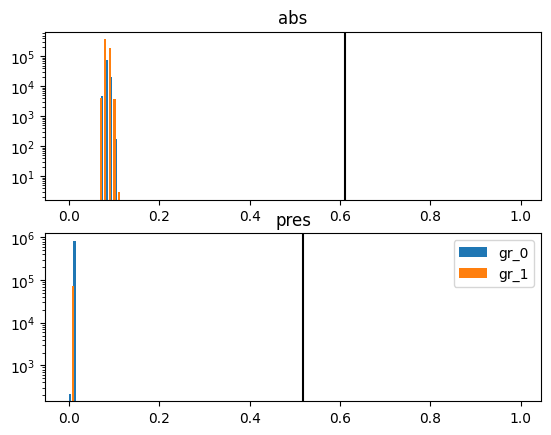

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 1


Validation: 0it [00:00, ?it/s]

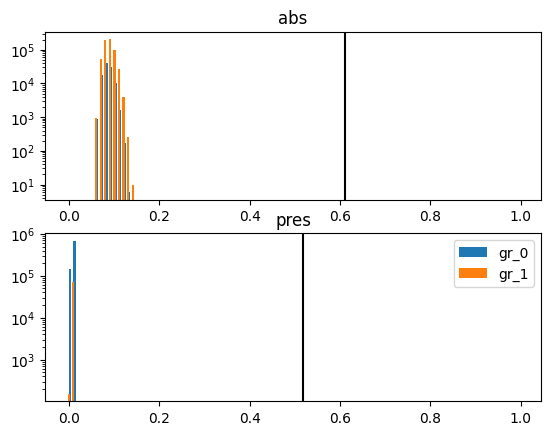

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 2


Validation: 0it [00:00, ?it/s]

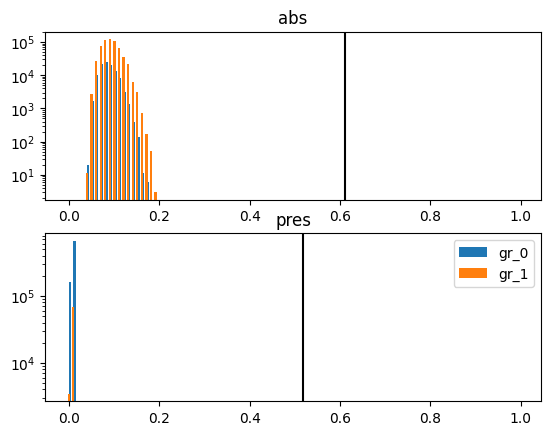

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 3


Validation: 0it [00:00, ?it/s]

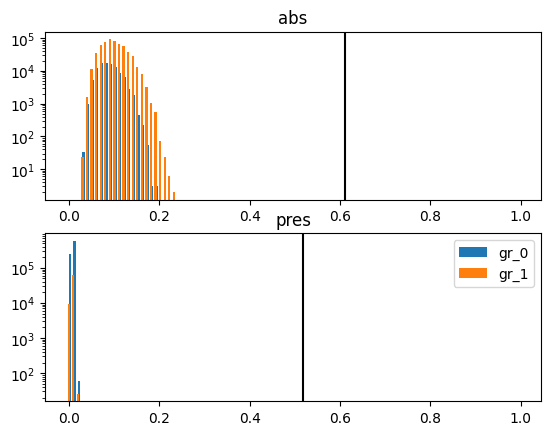

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 4


Validation: 0it [00:00, ?it/s]

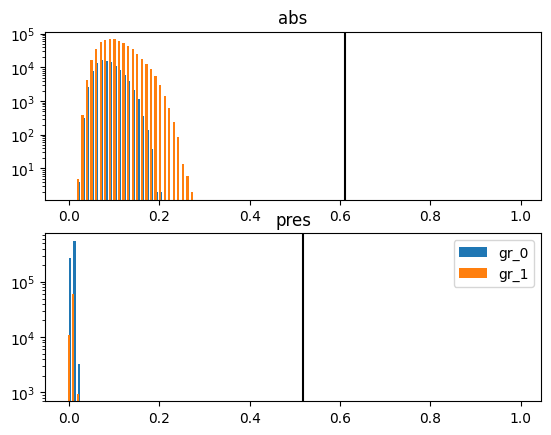

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 5


Validation: 0it [00:00, ?it/s]

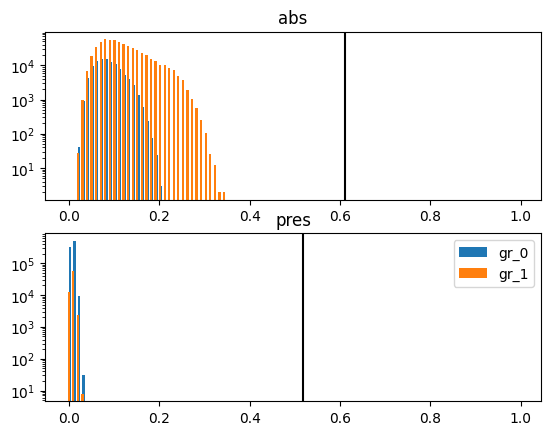

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 6


Validation: 0it [00:00, ?it/s]

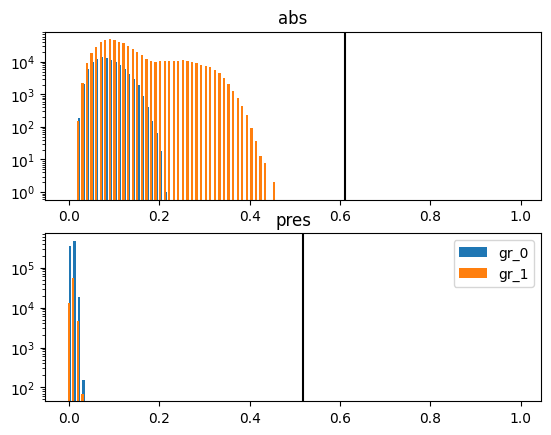

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 7


Validation: 0it [00:00, ?it/s]

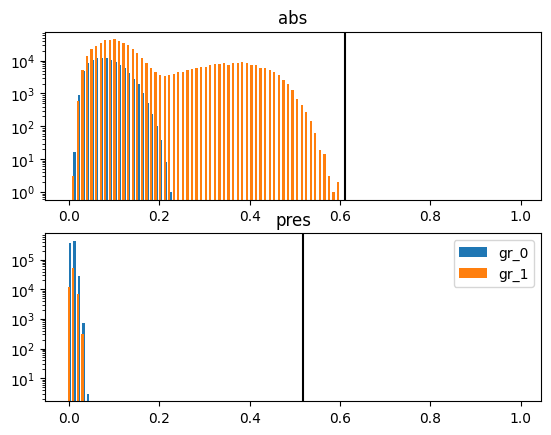

No improve counter : 1280
item counter : 1280
ratio : 0.9992193598750976
 ratio number predicted/items: 0.0
current epoch: 8


Validation: 0it [00:00, ?it/s]

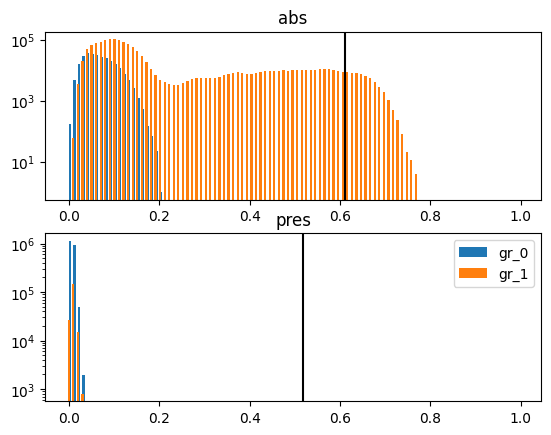

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 1247
item counter : 3292
ratio : 0.3786820528393562
 ratio number predicted/items: 18.160340115396295
current epoch: 9


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory lightning_logs/version_83/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNetBis       | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


1


Sanity Checking: 0it [00:00, ?it/s]

/tmp/ipykernel_7205/2830455942.py:187: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.set_yscale('log')
/tmp/ipykernel_7205/2830455942.py:193: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax2.set_yscale('log')


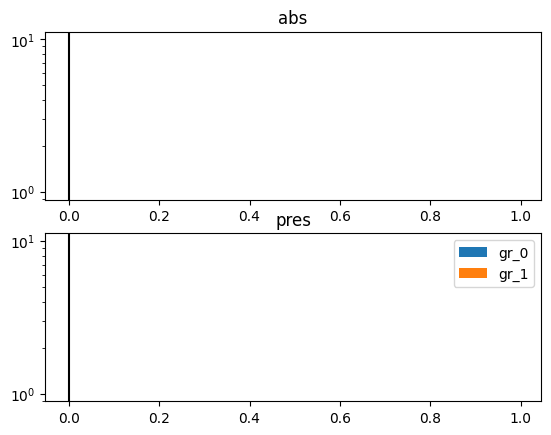

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


Training: 0it [00:00, ?it/s]

/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/loops/optimization/automatic.py:129: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Validation: 0it [00:00, ?it/s]

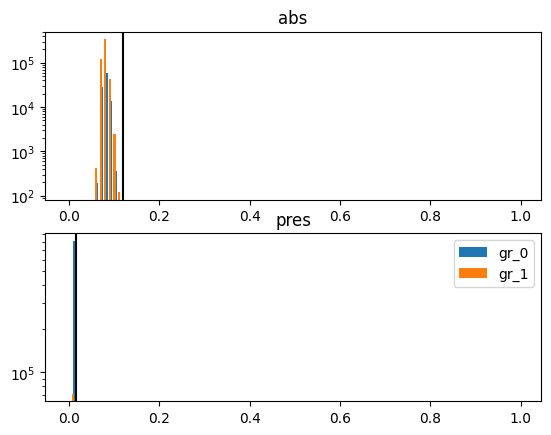

No improve counter : 1246
item counter : 1252
ratio : 0.994413407821229
 ratio number predicted/items: 0.00558659217877095
current epoch: 0


Validation: 0it [00:00, ?it/s]

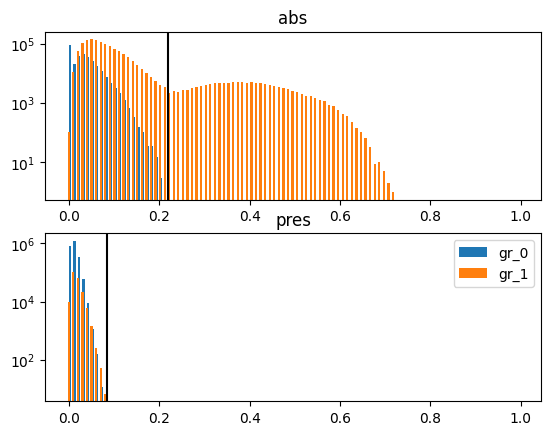

No improve counter : 1230
item counter : 3728
ratio : 0.32984714400643605
 ratio number predicted/items: 33.18181818181818
current epoch: 1


Validation: 0it [00:00, ?it/s]

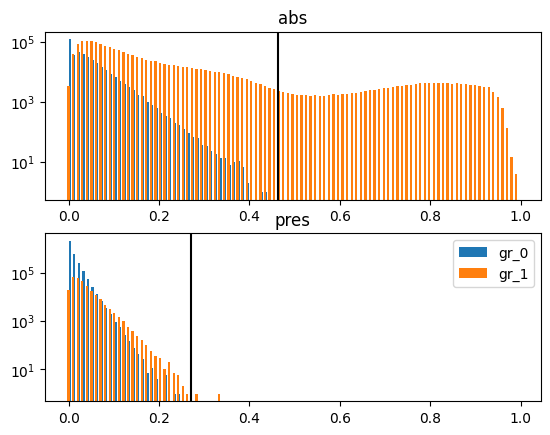

No improve counter : 1239
item counter : 4787
ratio : 0.25877192982456143
 ratio number predicted/items: 30.972013366750208
current epoch: 2


Validation: 0it [00:00, ?it/s]

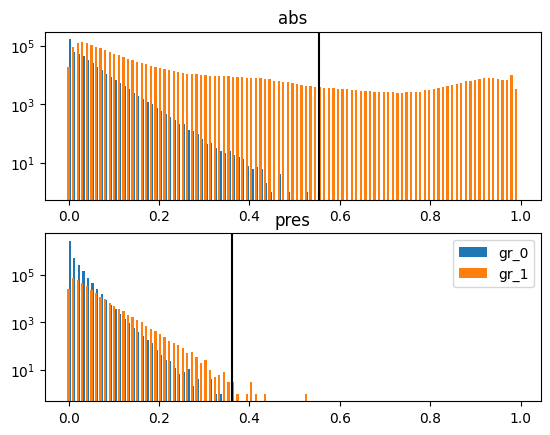

No improve counter : 1231
item counter : 5656
ratio : 0.21760650521477815
 ratio number predicted/items: 34.284426374403395
current epoch: 3


Validation: 0it [00:00, ?it/s]

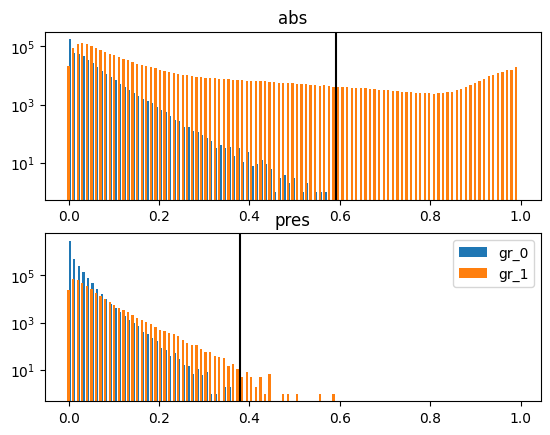

No improve counter : 1229
item counter : 5980
ratio : 0.20548403277043972
 ratio number predicted/items: 37.10081926099315
current epoch: 4


Validation: 0it [00:00, ?it/s]

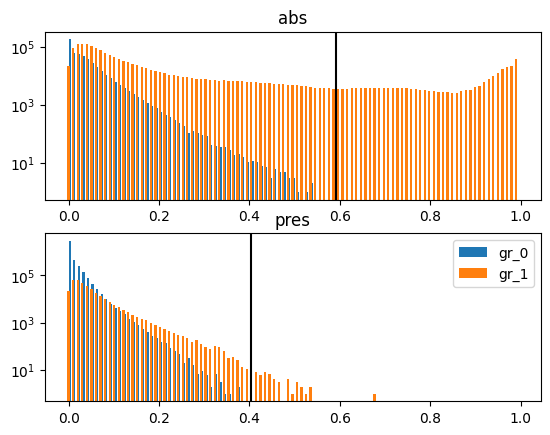

No improve counter : 1232
item counter : 5972
ratio : 0.20626151012891344
 ratio number predicted/items: 40.74183827222501
current epoch: 5


Validation: 0it [00:00, ?it/s]

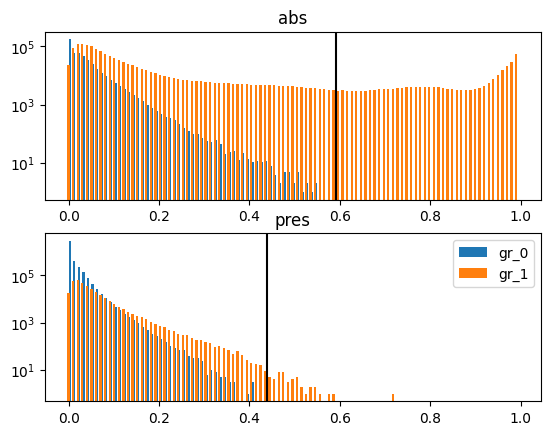

No improve counter : 1227
item counter : 5847
ratio : 0.20981532147742818
 ratio number predicted/items: 44.54976060191518
current epoch: 6


Validation: 0it [00:00, ?it/s]

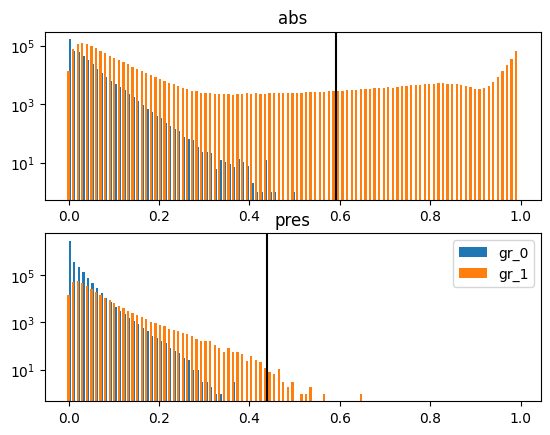

No improve counter : 1225
item counter : 5627
ratio : 0.21766169154228857
 ratio number predicted/items: 51.17857142857143
current epoch: 7


Validation: 0it [00:00, ?it/s]

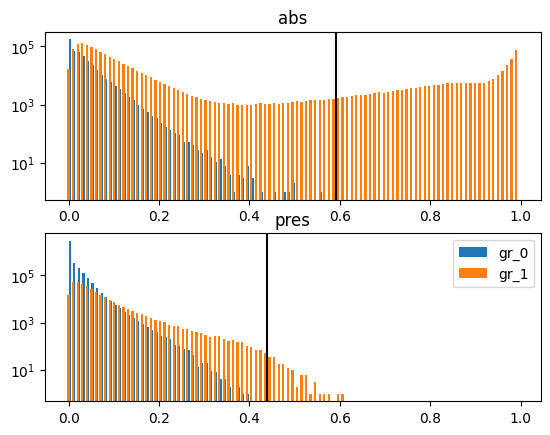

No improve counter : 1233
item counter : 5721
ratio : 0.21548409646976582
 ratio number predicted/items: 52.79360363509262
current epoch: 8


Validation: 0it [00:00, ?it/s]

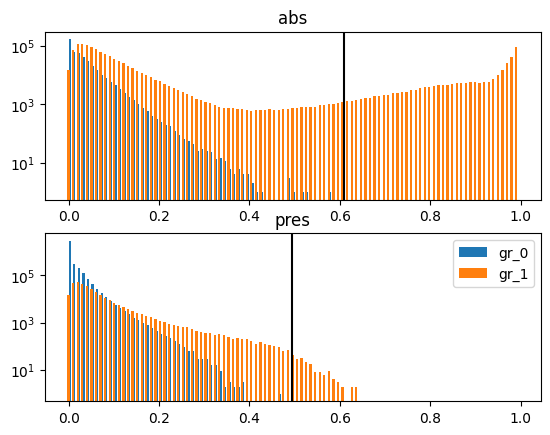

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 1227
item counter : 5530
ratio : 0.2218405351654312
 ratio number predicted/items: 55.611824263243534
current epoch: 9


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNetBis       | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


2


Sanity Checking: 0it [00:00, ?it/s]

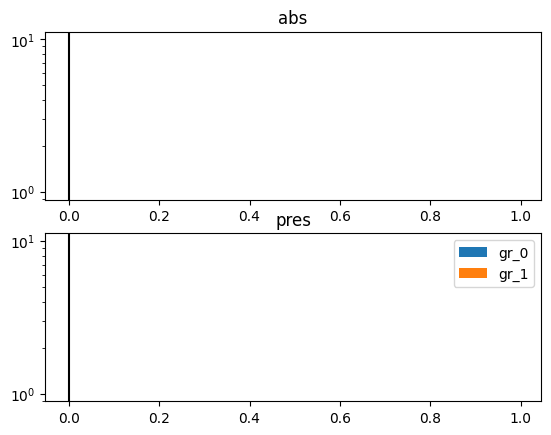

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

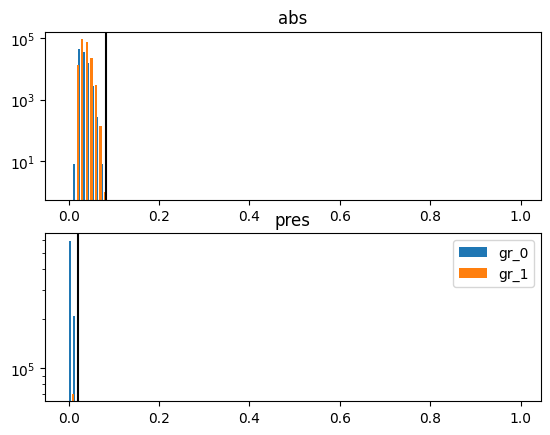

No improve counter : 1233
item counter : 1236
ratio : 0.9967663702506063
 ratio number predicted/items: 0.004850444624090542
current epoch: 0


Validation: 0it [00:00, ?it/s]

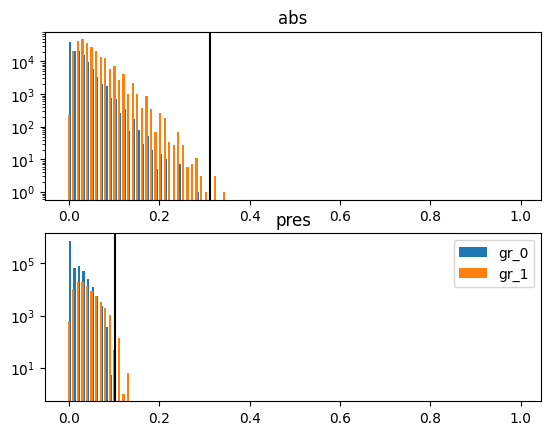

No improve counter : 1237
item counter : 1500
ratio : 0.8241172551632245
 ratio number predicted/items: 0.22318454363757495
current epoch: 1


Validation: 0it [00:00, ?it/s]

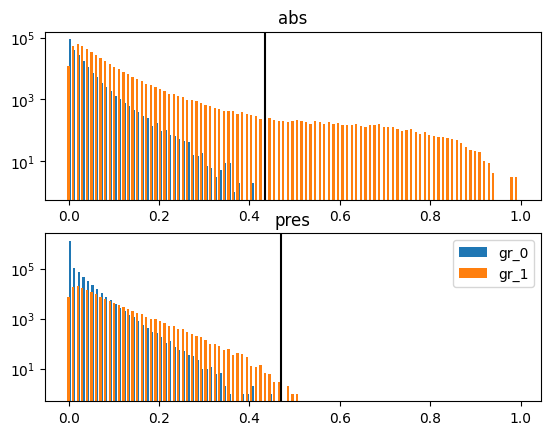

No improve counter : 1234
item counter : 2578
ratio : 0.4784800310197751
 ratio number predicted/items: 2.7309034509499805
current epoch: 2


Validation: 0it [00:00, ?it/s]

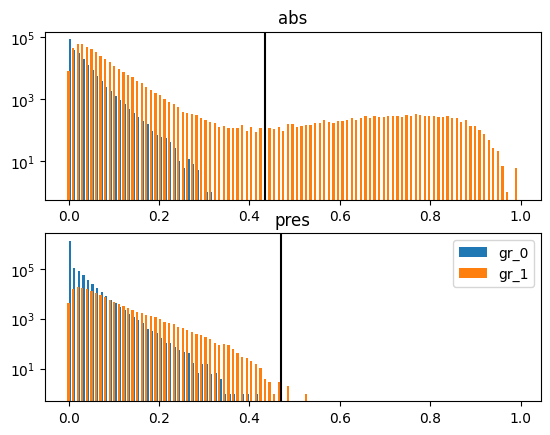

No improve counter : 1224
item counter : 2672
ratio : 0.45791245791245794
 ratio number predicted/items: 3.9135802469135803
current epoch: 3


Validation: 0it [00:00, ?it/s]

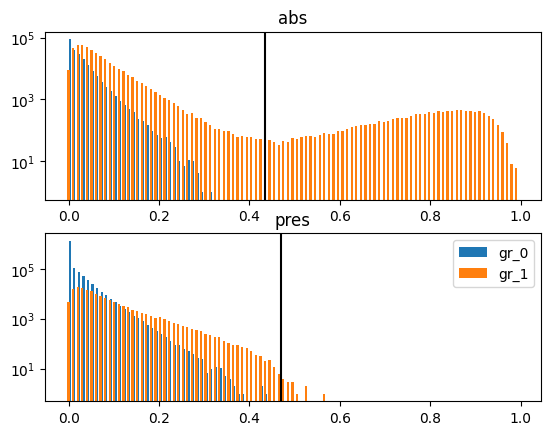

No improve counter : 1228
item counter : 2685
ratio : 0.4571854058078928
 ratio number predicted/items: 4.1407297096053615
current epoch: 4


Validation: 0it [00:00, ?it/s]

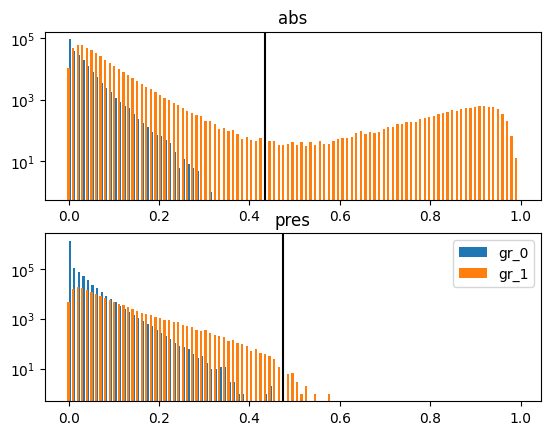

No improve counter : 1227
item counter : 2701
ratio : 0.45410806809770543
 ratio number predicted/items: 4.208734270910437
current epoch: 5


Validation: 0it [00:00, ?it/s]

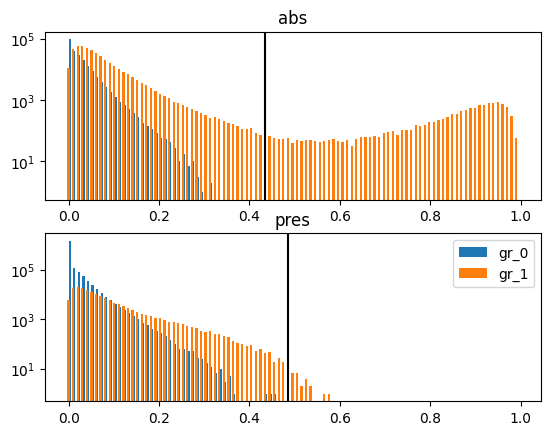

No improve counter : 1228
item counter : 2795
ratio : 0.43919885550786836
 ratio number predicted/items: 4.253576537911302
current epoch: 6


Validation: 0it [00:00, ?it/s]

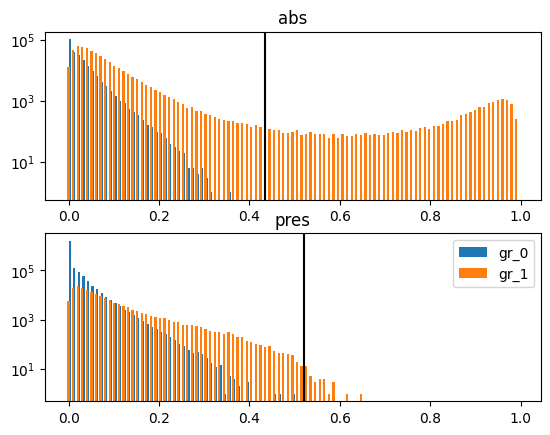

No improve counter : 1230
item counter : 2959
ratio : 0.4155405405405405
 ratio number predicted/items: 4.475675675675675
current epoch: 7


Validation: 0it [00:00, ?it/s]

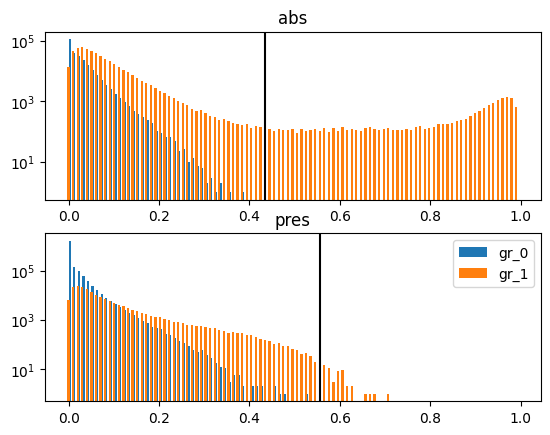

No improve counter : 1230
item counter : 3155
ratio : 0.3897338403041825
 ratio number predicted/items: 4.769961977186312
current epoch: 8


Validation: 0it [00:00, ?it/s]

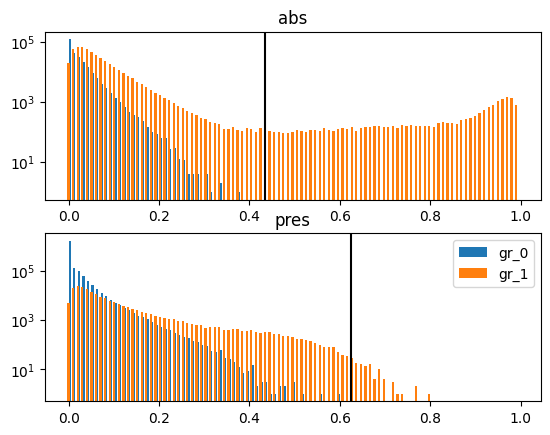

`Trainer.fit` stopped: `max_epochs=10` reached.


No improve counter : 1227
item counter : 3261
ratio : 0.3761496014714899
 ratio number predicted/items: 4.848252605763335
current epoch: 9


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | net            | SmallNetBis       | 514   
1 | sym_preprocess | SymPreprocess     | 8.5 M 
2 | bcewll         | BCEWithLogitsLoss | 0     
3 | auroc          | BinaryAUROC       | 0     
-----------------------------------------------------
514       Trainable params
8.5 M     Non-trainable params
8.5 M     Total params
34.014    Total estimated model params size (MB)


3


Sanity Checking: 0it [00:00, ?it/s]

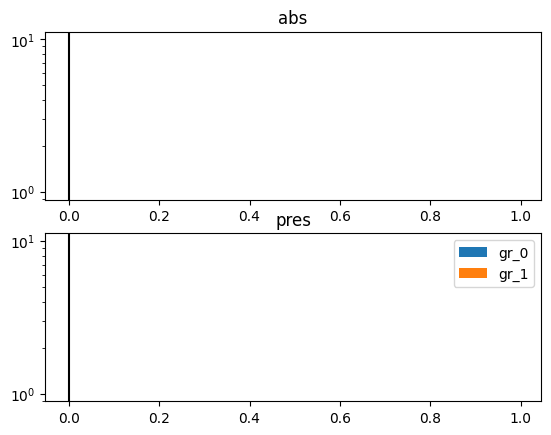

No improve counter : 0
item counter : 0
ratio : 0.0
 ratio number predicted/items: 0.0
current epoch: 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

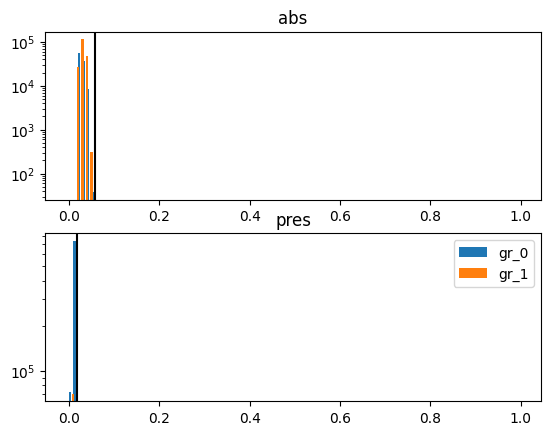

No improve counter : 1247
item counter : 1247
ratio : 0.999198717948718
 ratio number predicted/items: 0.0
current epoch: 0


Validation: 0it [00:00, ?it/s]

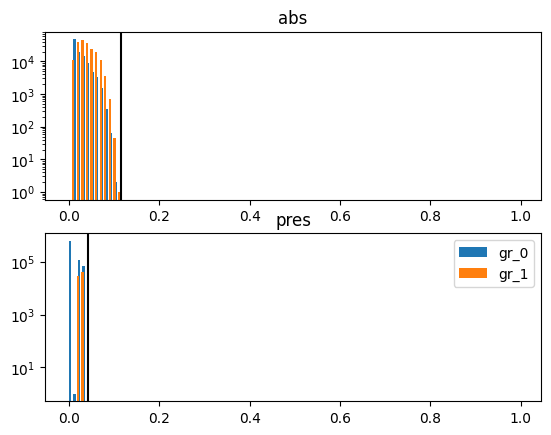

No improve counter : 1247
item counter : 1247
ratio : 0.999198717948718
 ratio number predicted/items: 0.0
current epoch: 1


Validation: 0it [00:00, ?it/s]

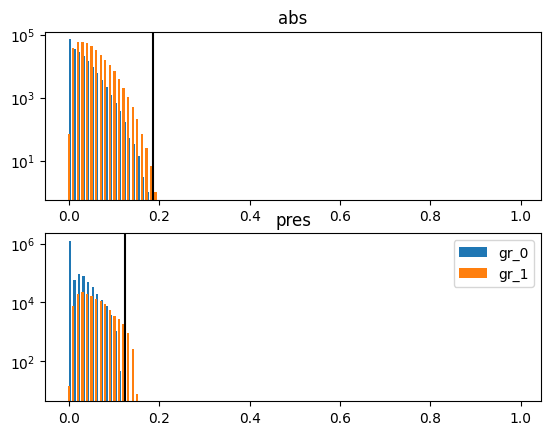

No improve counter : 1230
item counter : 2454
ratio : 0.5010183299389002
 ratio number predicted/items: 0.8773930753564155
current epoch: 2


Validation: 0it [00:00, ?it/s]

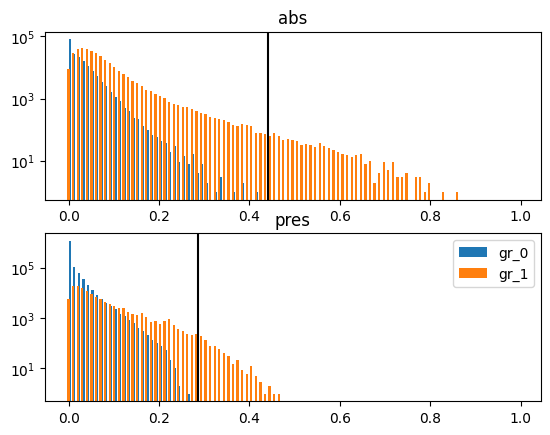

No improve counter : 1234
item counter : 2235
ratio : 0.5518783542039356
 ratio number predicted/items: 0.881484794275492
current epoch: 3


Validation: 0it [00:00, ?it/s]

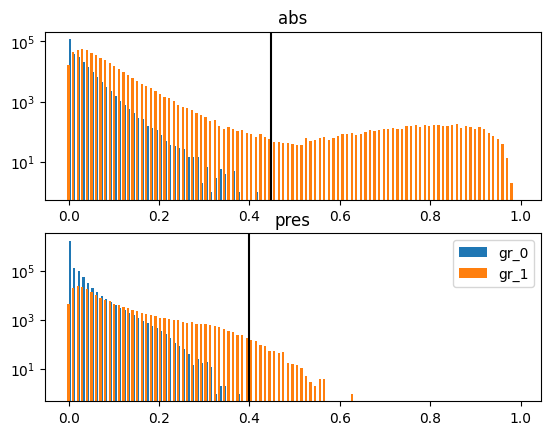

No improve counter : 1225
item counter : 3093
ratio : 0.39592760180995473
 ratio number predicted/items: 2.13639301874596
current epoch: 4


Validation: 0it [00:00, ?it/s]

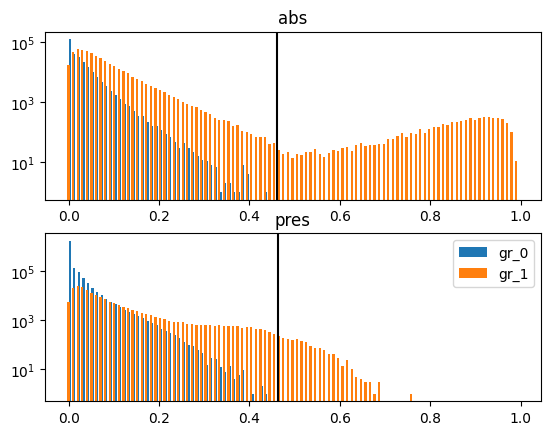

No improve counter : 1225
item counter : 3322
ratio : 0.36864279265723743
 ratio number predicted/items: 2.269334938308757
current epoch: 5


In [16]:
prev_nets= []
for i in range(12):
    model_checkpoint = ModelCheckpoint(monitor='ratio_number_predicted_per_items', mode='max')
    trainer = pl.Trainer(
    max_epochs=10,
#     max_epochs=40,
    accelerator='cuda',
    devices=1,
    log_every_n_steps=1,
    # logger=pl.loggers.CSVLogger(save_dir="logs/"),
    reload_dataloaders_every_n_epochs=1,
    logger=tensorboard,
    callbacks=[model_checkpoint]
    )
    print(i)
    model = SudokuLightning(
        lr=0.01,
        prev_nets=prev_nets,
        coef_0 = 10,
    )
    _ = trainer.fit(model,)
#     model.below_threshold_coef=0.9
#     model = model.load_from_checkpoint(model_checkpoint.best_model_path)
#     print(model_checkpoint.best_model_path)
#     trainer.validate(model=model)
#     if trainer.logged_metrics['no_improve_counter'].item()==0:
    prev_nets.append((model.net, (model.threshold_abs, model.threshold_pres)))
    

In [ ]:
import joblib
dump_list = []
for i, (prev_net, (th_abs, th_pres) )in enumerate(prev_nets):
    net_name = f"net_{i}"
    torch.save(prev_net.state_dict(), net_name)
    dump_list.append((net_name,(th_abs, th_pres)))
joblib.dump(dump_list, "thresholds.dump")

In [ ]:
model.no_improve_counter

In [23]:
len(prev_nets)

10

In [24]:
from copy import copy

def predict_from_net(x, net, th_abs, th_pres):
    x = model.sym_preprocess.forward(x)
    x = net(x)
    new_x = torch.empty(x.shape, device=x.device)
    new_x[:,0] = (x[:,0] > th_abs).float()
    new_x[:,1] = (x[:,1] > th_pres).float()
    return new_x

def predict_fix_from_net(x, y,  net, th_abs, th_pres):
    
    output = model.sym_preprocess.forward(x)
    output = net(output)
    new_x = torch.empty(x.shape, device=x.device)
    new_x[:,0] = (output[:,0] > th_abs).float()
    new_x[:,1] = (output[:,1] > th_pres).float()
    max_th_abs = output[:,0][(x[:,0]==0)&(y[:,0]==0)].max().item()
    max_th_pres = output[:,1][(x[:,1]==0)&(y[:,1]==0)].max().item()
    
    return new_x, max(th_abs, max_th_abs), max(th_pres, max_th_pres)


def forward_from_prev_nets(x,y):

    for net, (th_abs, th_pres) in prev_nets:
        new_x = torch.zeros(x.shape, device=x.device)
        with torch.no_grad():
            sub_new_x = predict_from_net(x, net.to(x.device), th_abs, th_pres)
        new_x[sub_new_x==1]=1
        new_x[x==1]=1
        print(f"errrors: {((new_x==1)&(y==0)).sum()}")
        new_x[(new_x==1)&(y==0)]=0
        if new_x.sum(dim=(1,2))>x.sum(dim=(1,2)):
            break
        x = new_x
    return new_x


def forward_from_prev_nets_all(x,y, prev_nets=prev_nets, raise_if_error=False, fix=False, full_loop=True):
    
    for i,(net, (th_abs, th_pres)) in enumerate(prev_nets):
        new_x = torch.zeros(x.shape, device=x.device)
        with torch.no_grad():
            if fix:
                sub_new_x, new_th_abs, new_th_pres = predict_fix_from_net(x, y, net.to(x.device), th_abs, th_pres)
                if (new_th_abs != th_abs) or (new_th_pres != th_pres):
                    prev_nets[i] = (net, (new_th_abs, new_th_pres))
            else:
                sub_new_x = predict_from_net(x, net.to(x.device), th_abs, th_pres)
        new_x[sub_new_x==1]=1
        new_x[x==1]=1
        n_errors = ((new_x==1)&(y==0)).sum(dim=(0,2))
        # print(f"errrors: {n_errors}")
        if n_errors.sum()>0:
            print(f"found errors : {n_errors}")
            print(f"model index : {i}")
            if raise_if_error:
                raise ValueError
        new_x[(new_x==1)&(y==0)]=0
        if new_x.sum()> x.sum() and not full_loop:
            break
        x = new_x
    return new_x

def fix_threshold(x,y,prev_nets, margin=0.05):
    x_feature = model.sym_preprocess.forward(x)
    new_prev_nets = []
    for net, (th_abs, th_pres) in prev_nets:
        
        output = net(x_feature)       
        max_th_abs = output[:,0][(x[:,0]==0)&(y[:,0]==0)].max().item()
        if th_abs < max_th_abs+margin:
            th_abs = max_th_abs+margin
        max_th_pres = output[:,1][(x[:,1]==0)&(y[:,1]==0)].max().item()
        if th_pres < max_th_pres+margin:
            th_pres = max_th_pres+margin  
        new_prev_nets.append((net, (th_abs, th_pres)))
    return new_prev_nets

In [35]:
print(test_x.sum())
print(test_x[:,1].sum())
display_as_dataframe(test_x)

tensor(234.)
tensor(26.)


In [36]:
new_x = forward_from_prev_nets_all(test_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(568.)
tensor(31.)


In [37]:
prev_x = new_x.clone()
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(581.)
tensor(32.)


In [38]:
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(587.)
tensor(33.)


In [39]:
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(594.)
tensor(34.)


In [40]:
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

tensor(594.)
tensor(34.)


In [32]:
from sudoku.loader import get_datasets
from tqdm.notebook import tqdm

In [33]:
train, test = get_datasets(train_size=5000, test_size=5000)

In [34]:
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, full_loop=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

  0%|          | 0/5000 [00:00<?, ?it/s]

found errors : tensor([0, 1])
model index : 1
found errors : tensor([0, 1])
model index : 1
found errors : tensor([0, 1])
model index : 1
found errors : tensor([0, 2])
model index : 1
No improvment


ValueError: 

In [31]:
# stop 
raise ValueError

ValueError: 

In [ ]:
for i in range(3):
    model_checkpoint = ModelCheckpoint(monitor='ratio_number_predicted_per_items', mode='max')
    trainer = pl.Trainer(
    max_epochs=20 if i==2 else 10,
#     max_epochs=40,
    accelerator='gpu',
    devices=1,
    log_every_n_steps=1,
    # logger=pl.loggers.CSVLogger(save_dir="logs/"),
    reload_dataloaders_every_n_epochs=1,
    logger=tensorboard,
    callbacks=[model_checkpoint]
    )
    print(i)
    model = SudokuLightning(
        lr=0.01,
        prev_nets=prev_nets,
        coef_0 = 10 if i==0 else 20,
    )
    _ = trainer.fit(model,)
#     model.below_threshold_coef=0.9
#     model = model.load_from_checkpoint(model_checkpoint.best_model_path)
#     print(model_checkpoint.best_model_path)
#     trainer.validate(model=model)
#     if trainer.logged_metrics['no_improve_counter'].item()==0:
    prev_nets.append((model.net, (model.threshold_abs, model.threshold_pres)))

In [ ]:
print(test_x.sum())
print(test_x[:,1].sum())
display_as_dataframe(test_x)

In [ ]:
new_x = forward_from_prev_nets_all(test_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

In [ ]:
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

In [ ]:
new_x = forward_from_prev_nets_all(new_x, test_y)
print(new_x.sum())
print(new_x[:,1].sum())
display_as_dataframe(new_x)

In [ ]:
new_x.reshape((2,9,9,9))[0,6:,6:,7]

In [ ]:
model.sym_preprocess(new_x).reshape(32,9,9,9)[:,:3,6:,7]

In [41]:
for i in range(3):
    model_checkpoint = ModelCheckpoint(monitor='ratio_number_predicted_per_items', mode='max')
    trainer = pl.Trainer(
    max_epochs=20 if i==2 else 10,
#     max_epochs=40,
    accelerator='gpu',
    devices=1,
    log_every_n_steps=1,
    # logger=pl.loggers.CSVLogger(save_dir="logs/"),
    reload_dataloaders_every_n_epochs=1,
    logger=tensorboard,
    callbacks=[model_checkpoint]
    )
    print(i)
    model = SudokuLightning(
        lr=0.01,
        prev_nets=prev_nets,
        coef_0 = 10 if i==0 else 20,
    )
    _ = trainer.fit(model,)
#     model.below_threshold_coef=0.9
#     model = model.load_from_checkpoint(model_checkpoint.best_model_path)
#     print(model_checkpoint.best_model_path)
#     trainer.validate(model=model)
#     if trainer.logged_metrics['no_improve_counter'].item()==0:
    prev_nets.append((model.net, (model.threshold_abs, model.threshold_pres)))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/seb/Perso/git/sudoku/sudoku_clean_v2/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory lightning_logs/version_83/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


0


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
import joblib
dump_list = []
for i, (prev_net, (th_abs, th_pres) )in enumerate(prev_nets):
    net_name = f"net_{i}"
    torch.save(prev_net.state_dict(), net_name)
    dump_list.append((net_name,(th_abs, th_pres)))
joblib.dump(dump_list, "thresholds.dump")

In [ ]:
for i in range(3):
    model_checkpoint = ModelCheckpoint(monitor='ratio_number_predicted_per_items', mode='max')
    trainer = pl.Trainer(
    max_epochs=10,
#     max_epochs=40,
    accelerator='gpu',
    devices=1,
    log_every_n_steps=1,
    # logger=pl.loggers.CSVLogger(save_dir="logs/"),
    reload_dataloaders_every_n_epochs=1,
    logger=tensorboard,
    callbacks=[model_checkpoint]
    )
    print(i)
    model = SudokuLightning(
        lr=0.01,
        prev_nets=prev_nets,
        coef_0 = 2,
    )
    _ = trainer.fit(model,)
#     model.below_threshold_coef=0.9
#     model = model.load_from_checkpoint(model_checkpoint.best_model_path)
#     print(model_checkpoint.best_model_path)
#     trainer.validate(model=model)
#     if trainer.logged_metrics['no_improve_counter'].item()==0:
    prev_nets.append((model.net, (model.threshold_abs, model.threshold_pres)))

In [32]:
from sudoku.loader import get_datasets
from tqdm.notebook import tqdm

In [33]:
train, test = get_datasets(train_size=5000, test_size=5000)

In [34]:
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, full_loop=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

  0%|          | 0/5000 [00:00<?, ?it/s]

found errors : tensor([0, 1])
model index : 1
found errors : tensor([0, 1])
model index : 1
found errors : tensor([0, 1])
model index : 1
found errors : tensor([0, 2])
model index : 1
No improvment


ValueError: 

In [ ]:
new_prev_nets = copy(prev_nets)
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=True)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
new_prev_nets = copy(prev_nets)
for x,y in tqdm(test):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=True)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(test):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
prev_nets

In [ ]:
new_prev_nets

In [ ]:
final_nets = []
marging = 0.3
for net_ths_1, net_ths_2 in zip(prev_nets, new_prev_nets):
    th_abs = net_ths_2[1][0] 
    if net_ths_1[1][0] != net_ths_2[1][0]:
        th_abs = net_ths_2[1][0] + marging
    else:
        th_abs = net_ths_2[1][0]
        
    if net_ths_1[1][1] != net_ths_2[1][1]:
        th_pres = net_ths_2[1][1] + marging
    else:
        th_pres = net_ths_2[1][1]
    final_nets.append((net_ths_2[0], (th_abs, th_pres)))

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=final_nets, fix=False, full_loop=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
new_prev_nets = copy(final_nets)
for x,y in tqdm(test):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=True)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=True)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(test):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=True, full_loop=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(train):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=final_nets, fix=False, full_loop=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
# new_prev_nets = copy(prev_nets)
for x,y in tqdm(test):
    x = x.view(1,2,729)
    y = y.view(1,2,729)
    
    while (x!=y).any():
        new_x = forward_from_prev_nets_all(x, y, raise_if_error=False, prev_nets=new_prev_nets, fix=False, full_loop=False)
        if (new_x == x).all():
            print("No improvment")
            raise ValueError
            break
        x = new_x

In [ ]:
import joblib
dump_list = []
for i, (prev_net, (th_abs, th_pres) )in enumerate(final_nets):
    net_name = f"f1_net_{i}"
    torch.save(prev_net.state_dict(), net_name)
    dump_list.append((net_name,(th_abs, th_pres)))
joblib.dump(dump_list, "final_1_nets_thresholds.dump")